# Projekt Podstawy Sztucznej Inteligencji 2023
Przewidywanie oceny filmu przez użytkowników

In [1396]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

Załadowanie danych:

In [1397]:
data = pd.read_csv("archive/movie_dataset.csv")
display(data.head())

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


Pierwsze spojrzenie na dataset:

In [1398]:
data.shape

(4803, 24)

In [1399]:
list(data.keys())

['index',
 'budget',
 'genres',
 'homepage',
 'id',
 'keywords',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'vote_average',
 'vote_count',
 'cast',
 'crew',
 'director']

In [1400]:
data.describe()

,index,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.000000,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2401.000000,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,1386.651002,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1200.500000,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,2401.000000,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,3601.500000,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,4802.000000,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [1401]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

Atrybuty numeryczne:
* index
* budget
* id
* popularity
* revenue
* runtime
* vote_average
* vote_count

Atrybuty kategoryczne:
* genres
* keywords
* original language
* status
* cast
* director

Usunięcie pewnych kolumn, takich jak overview lub title

In [1402]:
drop_list = ['id', 'homepage', 'original_title', 'title', 'overview', 'spoken_languages', 'tagline', 'crew']
data=data.drop(drop_list, axis=1)
data.head()

,index,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,status,vote_average,vote_count,cast,director
0,0,237000000,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,Released,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron
1,1,300000000,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,Released,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski
2,2,245000000,Action Adventure Crime,spy based on novel secret agent sequel mi6,en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,Released,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,Sam Mendes
3,3,250000000,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,Released,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,Released,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Andrew Stanton


Sprawdzenie missing values:

In [1403]:
null_counts = data.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
index                     0
budget                    0
genres                   28
keywords                412
original_language         0
popularity                0
production_companies      0
production_countries      0
release_date              1
revenue                   0
runtime                   2
status                    0
vote_average              0
vote_count                0
cast                     43
director                 30
dtype: int64


Niewielki procent danych w kolumnach 'cast', 'director' i 'genres' ma missing values - usuniemy te wiersze.
Więcej brakujących danych - 412 - jest w kolumnie keywords - usuniemy tą kolumnę.
W przypadku runtime i release_date uzupełnimy średnią.
Datę zamienimy na rok wydania filmu

In [1404]:
data['release_date'] = pd.to_datetime(data['release_date'])
data['release_date'] = data['release_date'].dt.year

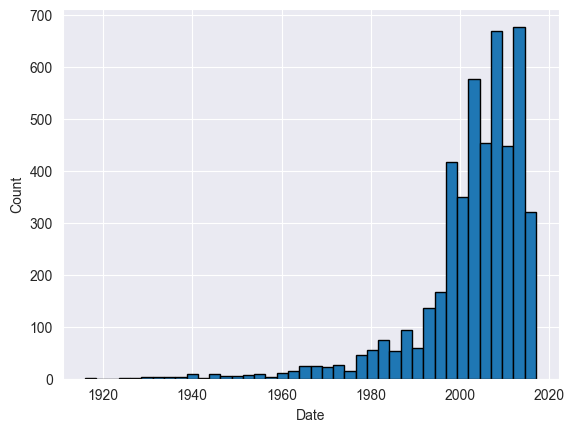

In [1405]:
plt.hist(data['release_date'], bins=40, edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

In [1406]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   keywords              4391 non-null   object 
 4   original_language     4803 non-null   object 
 5   popularity            4803 non-null   float64
 6   production_companies  4803 non-null   object 
 7   production_countries  4803 non-null   object 
 8   release_date          4802 non-null   float64
 9   revenue               4803 non-null   int64  
 10  runtime               4801 non-null   float64
 11  status                4803 non-null   object 
 12  vote_average          4803 non-null   float64
 13  vote_count            4803 non-null   int64  
 14  cast                  4760 non-null   object 
 15  director             

In [1407]:
data=data.drop('keywords', axis=1)
data['runtime'] = data['runtime'].astype('float').fillna(data['runtime'].astype('float').mean())
data['release_date'] = data['release_date'].astype('float').fillna(data['release_date'].astype('float').mean())
data['release_date'] = data['release_date'].astype('int')
data.dropna(inplace= True)

In [1408]:
null_counts = data.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
index                   0
budget                  0
genres                  0
original_language       0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
status                  0
vote_average            0
vote_count              0
cast                    0
director                0
dtype: int64


Sprawdzenie unikalnych reżyserów:

In [1409]:
data['director'].nunique()

2321

2321 unikalnych wartości - usuniemy tą kolumnę i kolumnę z obsadą:

In [1410]:
data=data.drop(['cast', 'director'], axis=1)

In [1411]:
data.head()

,index,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,status,vote_average,vote_count
0,0,237000000,Action Adventure Fantasy Science Fiction,en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009,2787965087,162.0,Released,7.2,11800
1,1,300000000,Adventure Fantasy Action,en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007,961000000,169.0,Released,6.9,4500
2,2,245000000,Action Adventure Crime,en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015,880674609,148.0,Released,6.3,4466
3,3,250000000,Action Crime Drama Thriller,en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012,1084939099,165.0,Released,7.6,9106
4,4,260000000,Action Adventure Science Fiction,en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012,284139100,132.0,Released,6.1,2124


# Najpopularniejsze gatunki, języki, kraje, statusy
Języki:

In [1412]:
data['original_language'].value_counts()

en    4443
fr      70
es      32
zh      27
de      26
hi      19
ja      16
it      14
cn      12
ru      11
ko      11
pt       9
da       7
sv       5
nl       4
fa       4
th       3
he       3
ta       2
cs       2
ro       2
id       2
ar       2
vi       1
sl       1
ps       1
no       1
ky       1
hu       1
pl       1
af       1
nb       1
tr       1
is       1
xx       1
te       1
el       1
Name: original_language, dtype: int64

Zamiana: 5 najpopularniejszych języków zostanie, reszta zamiana etykiety na 'other'

In [1413]:
most_rare_languages = data['original_language'].value_counts().tail(37-5).index.tolist()
data.loc[data['original_language'].isin(most_rare_languages), 'original_language'] = 'other'

In [1414]:
data['original_language'].value_counts()

en       4443
other     142
fr         70
es         32
zh         27
de         26
Name: original_language, dtype: int64

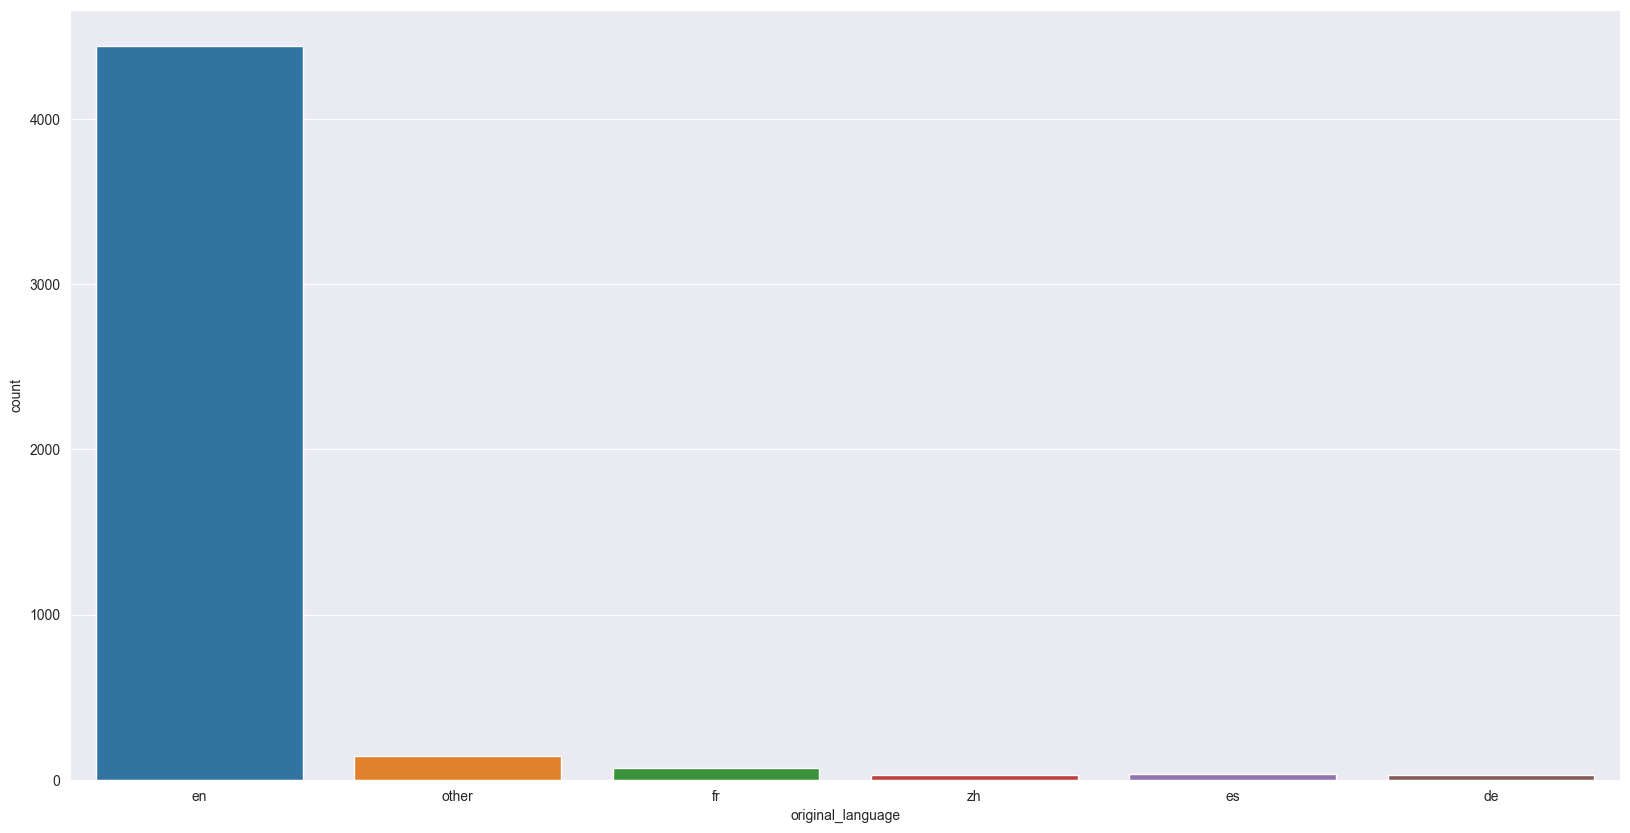

In [1415]:
plt.figure(figsize=(20, 10))
sns.countplot(x='original_language', data=data)
plt.show()

Gatunki:

In [1416]:
data['genres'] = data['genres'].str.split().apply(lambda x: x[0])

In [1417]:
data.head()

,index,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,status,vote_average,vote_count
0,0,237000000,Action,en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009,2787965087,162.0,Released,7.2,11800
1,1,300000000,Adventure,en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007,961000000,169.0,Released,6.9,4500
2,2,245000000,Action,en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015,880674609,148.0,Released,6.3,4466
3,3,250000000,Action,en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012,1084939099,165.0,Released,7.6,9106
4,4,260000000,Action,en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012,284139100,132.0,Released,6.1,2124


In [1418]:
data['genres'].replace('Science', 'Science Fiction', inplace= True)

In [1419]:
genres = data['genres'].unique()
print(data['genres'].value_counts())

Drama              1202
Comedy             1038
Action              753
Adventure           339
Horror              299
Crime               195
Thriller            194
Animation           122
Fantasy             117
Romance             105
Science Fiction      96
Documentary          71
Family               53
Mystery              41
Music                34
Western              27
History              25
War                  24
TV                    4
Foreign               1
Name: genres, dtype: int64


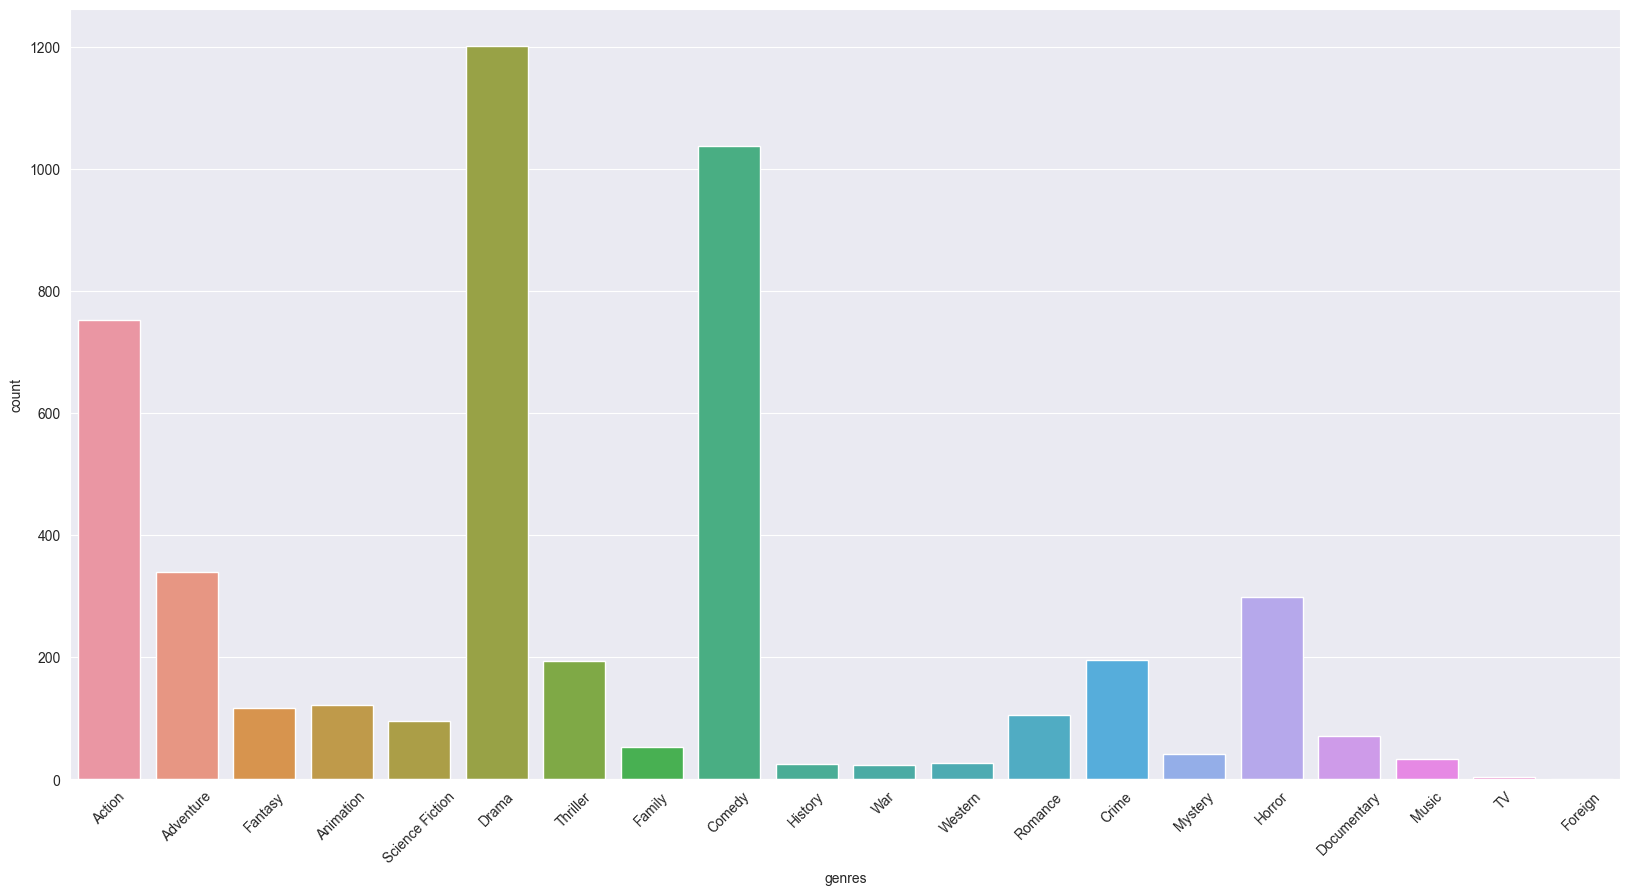

In [1420]:
plt.figure(figsize=(20, 10))
sns.countplot(x='genres', data=data)
plt.xticks(rotation=45)
plt.show()

Kraje:

In [1421]:
data['production_countries'].value_counts()

[{"iso_3166_1": "US", "name": "United States of America"}]                                                                                            2959
[{"iso_3166_1": "GB", "name": "United Kingdom"}, {"iso_3166_1": "US", "name": "United States of America"}]                                             181
[]                                                                                                                                                     139
[{"iso_3166_1": "GB", "name": "United Kingdom"}]                                                                                                       131
[{"iso_3166_1": "DE", "name": "Germany"}, {"iso_3166_1": "US", "name": "United States of America"}]                                                    119
                                                                                                                                                      ... 
[{"iso_3166_1": "CA", "name": "Canada"}, {"iso_3166_1": "IT", "name": 

Niektóre filmy nie mają wpisanego kraju produkcji - jest ich 139, więc usuniemy wiersze bez kraju produkcji:

In [1422]:
data['production_countries'] = data['production_countries'].apply(lambda x: json.loads(x))
data = data[data['production_countries'].apply(lambda x: len(x) > 0)]
data['production_countries'] = data['production_countries'].apply(lambda x: x[0])

In [1423]:
data['production_countries'].value_counts()

{'iso_3166_1': 'US', 'name': 'United States of America'}    3083
{'iso_3166_1': 'GB', 'name': 'United Kingdom'}               374
{'iso_3166_1': 'CA', 'name': 'Canada'}                       219
{'iso_3166_1': 'DE', 'name': 'Germany'}                      200
{'iso_3166_1': 'FR', 'name': 'France'}                       173
                                                            ... 
{'iso_3166_1': 'PH', 'name': 'Philippines'}                    1
{'iso_3166_1': 'BA', 'name': 'Bosnia and Herzegovina'}         1
{'iso_3166_1': 'PA', 'name': 'Panama'}                         1
{'iso_3166_1': 'SG', 'name': 'Singapore'}                      1
{'iso_3166_1': 'KE', 'name': 'Kenya'}                          1
Name: production_countries, Length: 67, dtype: int64

Wyciągniemy z tego państwo:

In [1424]:
data['production_countries'] = data['production_countries'].apply(lambda x: list(x.values())[1])

Zamiana: państwa, które mają mniej niż 30 filmów połączone w 'other_country':

In [1425]:
country_counts = data['production_countries'].value_counts()
most_rare_languages = country_counts[country_counts < 30].index.tolist()
data.loc[data['production_countries'].isin(most_rare_languages), 'production_countries'] = 'other_country'
data['production_countries'].value_counts()

United States of America    3083
United Kingdom               374
other_country                319
Canada                       219
Germany                      200
France                       173
Australia                     87
China                         40
India                         38
Japan                         34
Spain                         34
Name: production_countries, dtype: int64

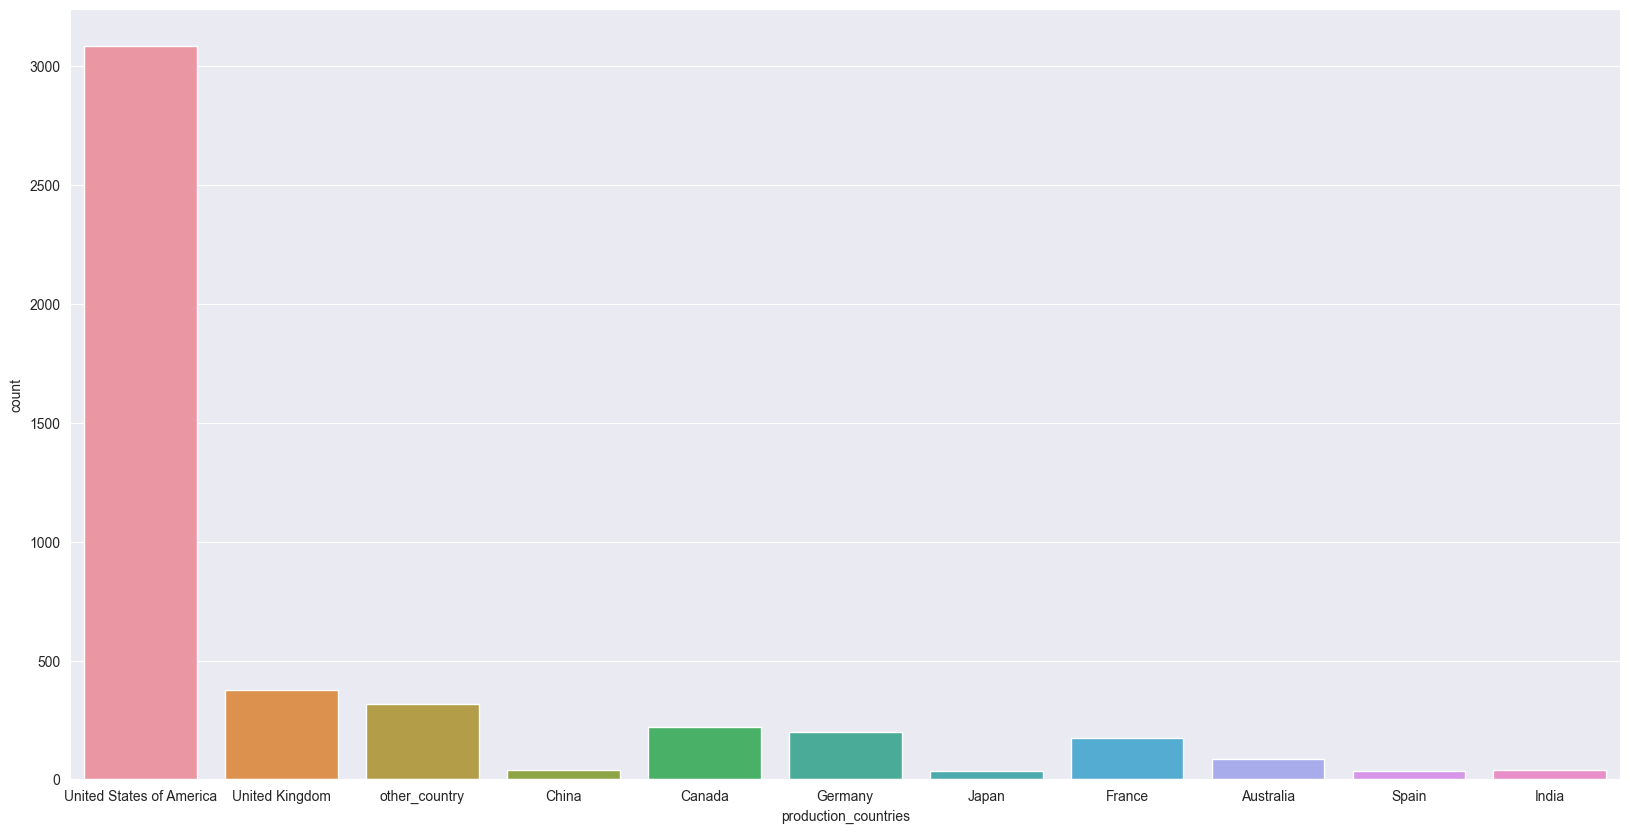

In [1426]:
plt.figure(figsize=(20, 10))
sns.countplot(x='production_countries', data=data)
plt.show()

Production companies:

In [1427]:
data['production_companies'].value_counts()

[]                                                                                                                                                                                                                                                                                                         179
[{"name": "Paramount Pictures", "id": 4}]                                                                                                                                                                                                                                                                   58
[{"name": "Universal Pictures", "id": 33}]                                                                                                                                                                                                                                                                  45
[{"name": "New Line Cinema", "id": 12}]                                                    

179 z nich nie ma informacji o producencie - usuniemy te filmy:

In [1428]:
data['production_companies'] = data['production_companies'].apply(lambda x: json.loads(x))
data = data[data['production_companies'].apply(lambda x: len(x) > 0)]
data['production_companies'] = data['production_companies'].apply(lambda x: x[0])

Wyciągniemy studio produkcyjne:

In [1429]:
data['production_companies'] = data['production_companies'].apply(lambda x: list(x.values())[1])

In [1430]:
data['production_companies'].nunique()

1298

1298 unikatowych wartości production_companies - usuniemy tą kolumnę:

In [1431]:
data=data.drop(['production_companies'], axis=1)

Status:

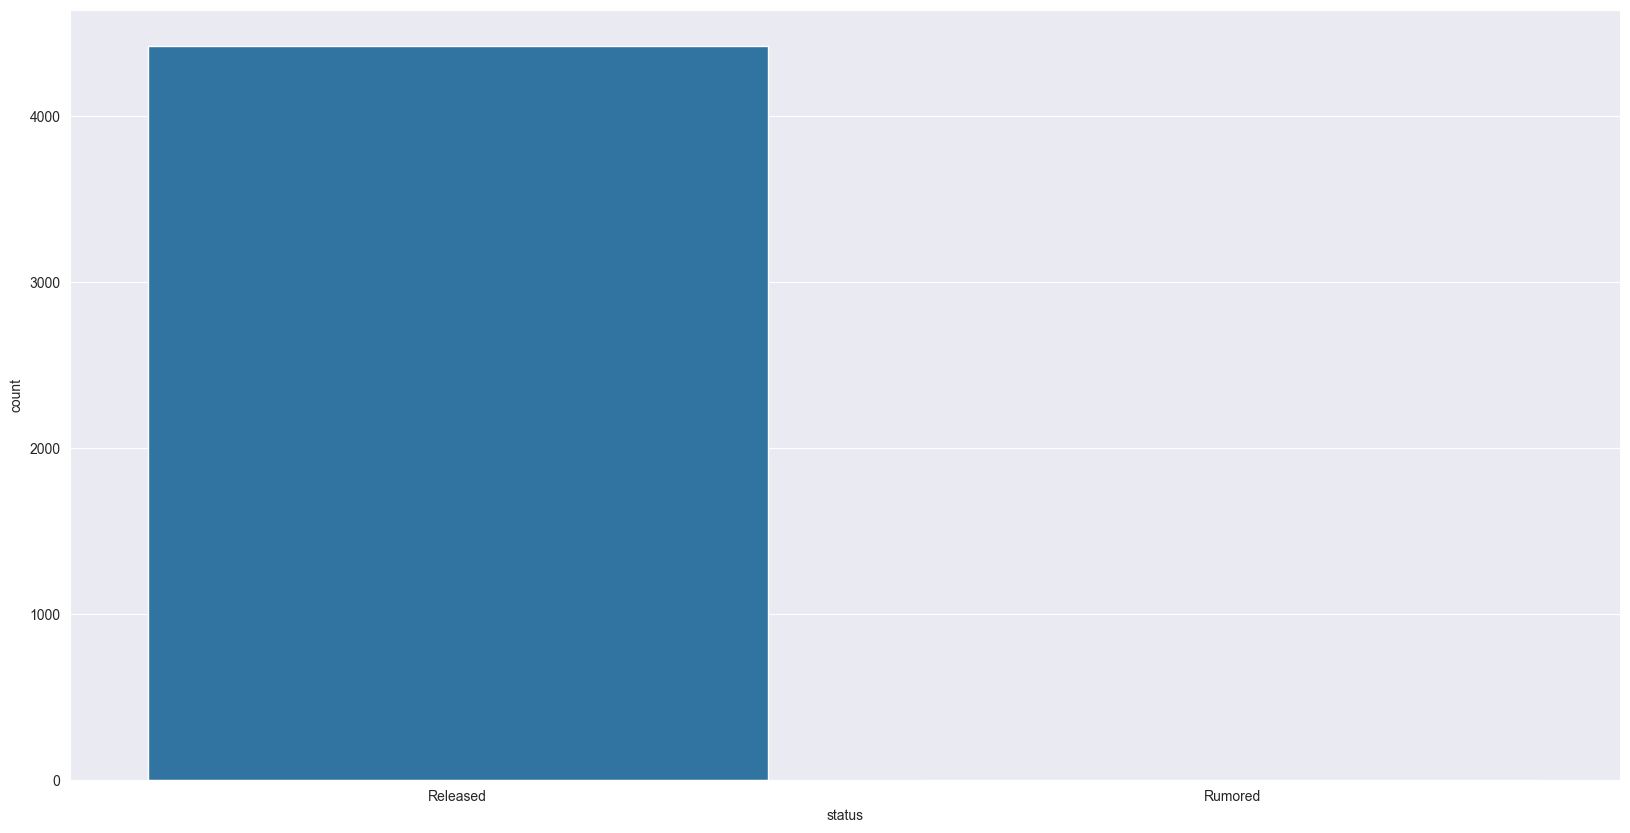

In [1432]:
plt.figure(figsize=(20, 10))
sns.countplot(x='status', data=data)
plt.show()

In [1433]:
data['status'].value_counts()

Released    4421
Rumored        1
Name: status, dtype: int64

1 produkcja ma status 'Rumored' - kolumny 'status' nie będziemy brali pod uwagę:

In [1434]:
data=data.drop(['status', 'index'], axis=1)
data['runtime'] = data['runtime'].astype('int')

# Po obróbce początkowej:

In [1435]:
data.head()

,budget,genres,original_language,popularity,production_countries,release_date,revenue,runtime,vote_average,vote_count
0,237000000,Action,en,150.437577,United States of America,2009,2787965087,162,7.2,11800
1,300000000,Adventure,en,139.082615,United States of America,2007,961000000,169,6.9,4500
2,245000000,Action,en,107.376788,United Kingdom,2015,880674609,148,6.3,4466
3,250000000,Action,en,112.312950,United States of America,2012,1084939099,165,7.6,9106
4,260000000,Action,en,43.926995,United States of America,2012,284139100,132,6.1,2124


Korelacje danych numerycznych:

C:\Users\agsud_z3nlru4\AppData\Local\Temp\ipykernel_14040\3770303982.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap = sns.diverging_palette(220, 10, as_cmap=True))


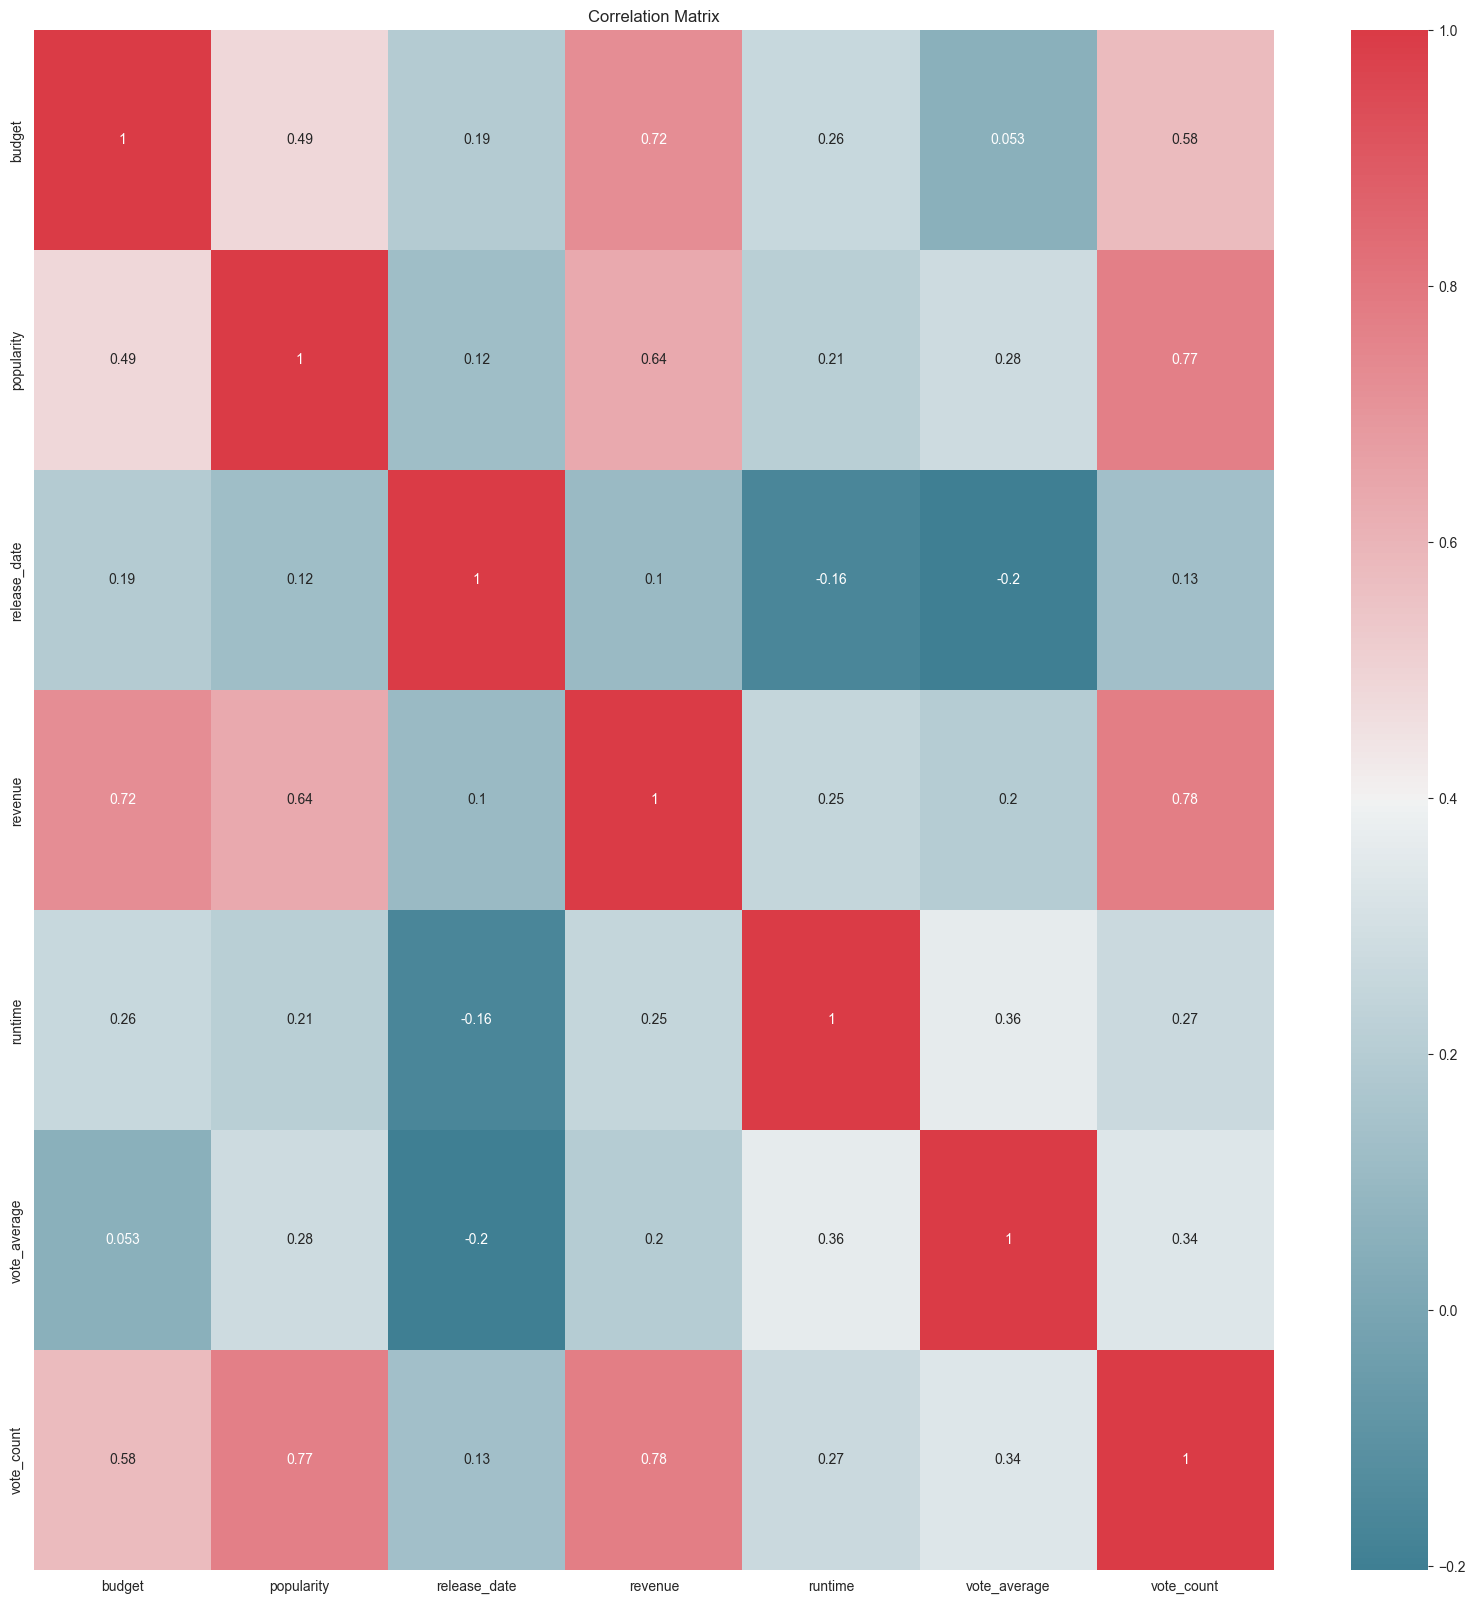

In [1436]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, cmap = sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Correlation Matrix')
plt.show()

Zamiana nie-numerycznych kolumn na numeryczne przy użyciu preprocessiong.LabelEncoder():

In [1437]:
# le = preprocessing.LabelEncoder()
# data['original_language'] = le.fit_transform(data['original_language'])
# data['production_countries'] = le.fit_transform(data['production_countries'])
# data['genres'] = le.fit_transform(data['genres'])

In [1438]:
# plt.figure(figsize=(20, 20))
# sns.heatmap(data.corr(), annot=True, cmap = sns.diverging_palette(220, 10, as_cmap=True))
# plt.title('Correlation Matrix')
# plt.show()

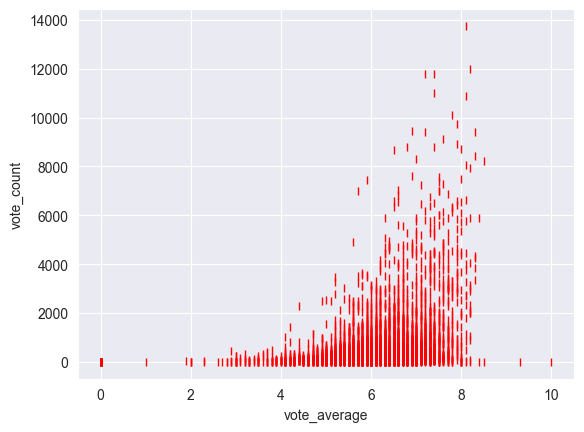

In [1439]:
plt.plot(data['vote_average'], data['vote_count'], 'r|')
plt.xlabel('vote_average')
plt.ylabel('vote_count')
plt.show()

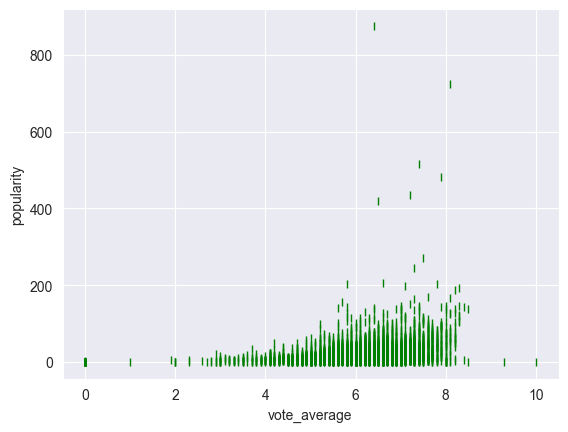

In [1440]:
plt.plot(data['vote_average'], data['popularity'], 'g|')
plt.xlabel('vote_average')
plt.ylabel('popularity')
plt.show()

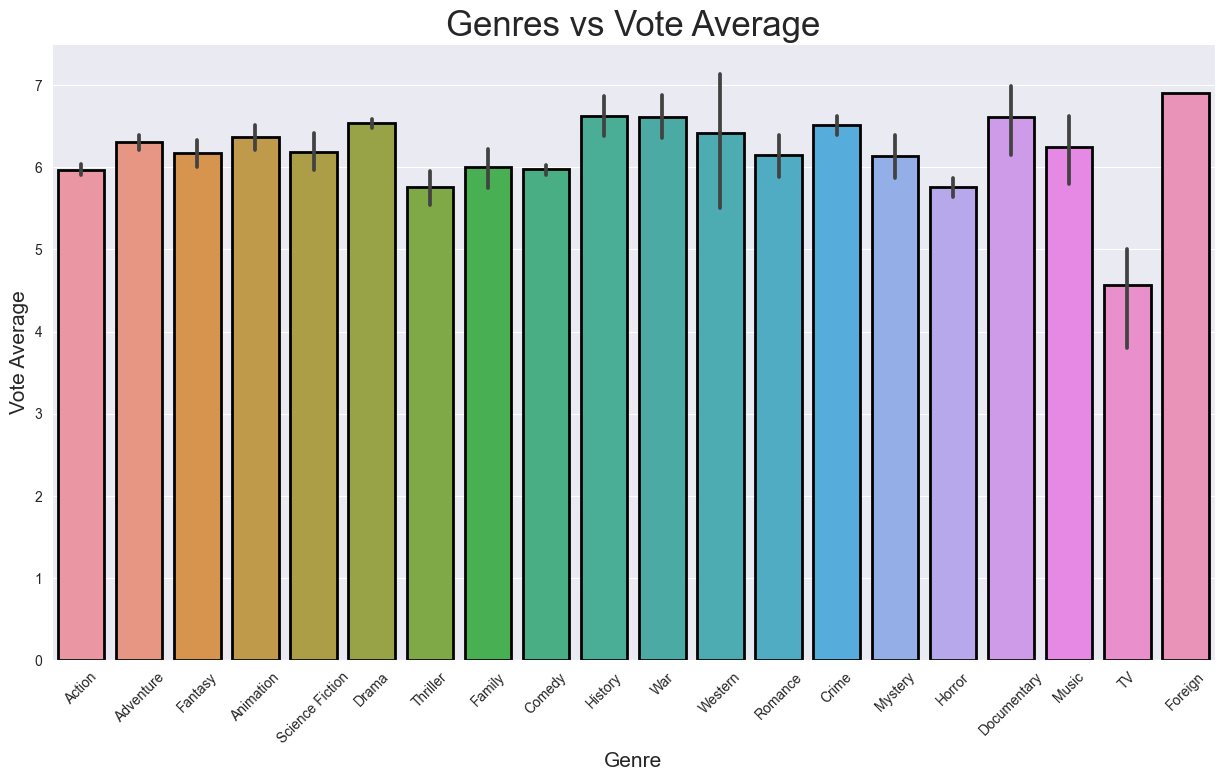

In [1441]:
plt.subplots(figsize = (15,8))
sns.barplot(x = "genres", y = "vote_average", data=data, edgecolor=(0,0,0), linewidth=2)
plt.title("Genres vs Vote Average", fontsize = 25)
plt.ylabel("Vote Average", fontsize = 15)
plt.xlabel("Genre",fontsize = 15)
plt.xticks(rotation=45)
plt.show()

In [1442]:
columns_name = list(data.columns)
columns_name.remove('vote_average')
data.head()

,budget,genres,original_language,popularity,production_countries,release_date,revenue,runtime,vote_average,vote_count
0,237000000,Action,en,150.437577,United States of America,2009,2787965087,162,7.2,11800
1,300000000,Adventure,en,139.082615,United States of America,2007,961000000,169,6.9,4500
2,245000000,Action,en,107.376788,United Kingdom,2015,880674609,148,6.3,4466
3,250000000,Action,en,112.312950,United States of America,2012,1084939099,165,7.6,9106
4,260000000,Action,en,43.926995,United States of America,2012,284139100,132,6.1,2124


Podział na train i test, przewidujemy 'vote_average'

In [1443]:
from keras.utils import np_utils

X = data.drop('vote_average', axis=1)
y = (data['vote_average'] * 10).values

# encoder = preprocessing.LabelEncoder()
# encoder.fit(y)
# y = encoder.transform(y)
# input_dim = len(data.columns) - 1
# class_dim = 9
# y = np_utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [1444]:
print(y_test.shape)

(885,)


In [1445]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed, shuffle=True)

Pipeline dla atrybutów numerycznych:

In [1446]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [1447]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['budget', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_count'])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [1448]:
num_pipeline.fit_transform(X_train)

array([[1.00000000e+08, 2.06529430e+01, 1.99900000e+03, 2.11989043e+08,
        1.21000000e+02, 4.82000000e+02],
       [1.76000003e+08, 8.53690800e+01, 2.01500000e+03, 1.83987723e+08,
        1.24000000e+02, 2.76800000e+03],
       [4.80000000e+07, 2.88037290e+01, 1.99100000e+03, 3.90493908e+08,
        1.43000000e+02, 9.09000000e+02],
       ...,
       [3.00000000e+07, 6.35397100e+00, 2.00500000e+03, 1.86182840e+07,
        1.08000000e+02, 1.61000000e+02],
       [0.00000000e+00, 5.77024600e+00, 1.99900000e+03, 0.00000000e+00,
        1.11000000e+02, 1.20000000e+01],
       [0.00000000e+00, 1.01311230e+01, 2.00100000e+03, 0.00000000e+00,
        8.40000000e+01, 1.63000000e+02]])

In [1449]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [1450]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['genres', 'original_language', 'production_countries'])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

In [1451]:
cat_pipeline.fit_transform(X_train)

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [1452]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [1453]:
# X_train = preprocess_pipeline.fit_transform(X_train)
# X_test = preprocess_pipeline.transform(X_test)

In [1454]:
pipe_log_reg = Pipeline(steps=[
    ('preprocessing', preprocess_pipeline),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter = 1000))])

param_grid_log_reg = {'classifier__C': [0.001, 0.01, 0.1, 1, 10]}

grid_log_reg = GridSearchCV(pipe_log_reg, param_grid_log_reg, cv=kfold, return_train_score=True, scoring= 'r2')
grid_log_reg.fit(X_train, y_train)
grid_log_reg.best_params_

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site

{'classifier__C': 0.01}

In [1455]:
# from sklearn.linear_model import LinearRegression
#
# pipe_lin = Pipeline(steps=[
#     ('preprocessing', preprocess_pipeline),
#     ('scaler', StandardScaler()),
#     ('regressor', LinearRegression())  ])
#
# # params_grid_lin =  { 'preprocessor__degree': [1, 2, 3, 4] }
#
# grid_lin = GridSearchCV(pipe_lin,
#                     # params_grid_lin,
#                     cv = kfold,
#                     refit = True,
#                     scoring= 'r2'
# )
#
# grid_lin.fit(X_train, y_train)
# grid_lin.best_params_

In [1456]:
from sklearn.linear_model import Ridge

pipe_ridge = Pipeline(steps=[
    ('preprocessing', preprocess_pipeline),
    ('scaler', StandardScaler()),
    ('regressor', Ridge())  ])

params_grid_ridge =  { 'regressor__alpha': [0.01, 0.1, 1, 10] }

grid_ridge = GridSearchCV(pipe_ridge,
                    params_grid_ridge,
                    cv = kfold,
                    refit = True,
                    scoring= 'r2'
)

grid_ridge.fit(X_train, y_train)
grid_ridge.best_params_

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site

{'regressor__alpha': 10}

In [1457]:
from sklearn.linear_model import Lasso

pipe_lasso = Pipeline(steps=[
    ('preprocessing', preprocess_pipeline),
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=10000))  ])

params_grid_lasso =  { 'regressor__alpha': [0.01, 0.1, 1, 10]}

grid_lasso = GridSearchCV(pipe_lasso,
                    params_grid_lasso,
                    cv = kfold,
                    refit = True,
                    scoring= 'r2'
)

grid_lasso.fit(X_train, y_train)
grid_lasso.best_params_

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site

{'regressor__alpha': 0.1}

In [1458]:
from sklearn.linear_model import ElasticNet

pipe_elasticnet = Pipeline(steps=[
    ('preprocessing', preprocess_pipeline),
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())  ])

params_grid_elasticnet =  {'regressor__alpha': [0.01, 0.1, 1, 10]}

grid_elasticnet = GridSearchCV(pipe_elasticnet,
                    params_grid_elasticnet,
                    cv = kfold,
                    refit = True,
                    scoring= 'r2')

grid_elasticnet.fit(X_train, y_train)
grid_elasticnet.best_params_

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site

{'regressor__alpha': 0.1}

In [1459]:
from sklearn.svm import SVC

pipe_rbf = Pipeline([('preprocessing', preprocess_pipeline),
                     ('scaler', StandardScaler()),
                     ('classifier', SVC(kernel='rbf'))])

params_grid_rbf = {
            'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid_rbf = GridSearchCV(pipe_rbf,
                        params_grid_rbf,
                        cv=kfold,
                        refit = True,
                        scoring= 'r2')

grid_rbf.fit(X_train, y_train)
grid_rbf.best_params_

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site

{'classifier__C': 100, 'classifier__gamma': 0.01}

In [1460]:
pipe_poly = Pipeline([('preprocessing', preprocess_pipeline),
                      ('scaler', StandardScaler()),
                      ('classifier', SVC(kernel='poly'))])

params_grid_poly = {
            'classifier__gamma': [0.001, 0.01, 0.1, 1],
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__degree': [1, 2, 3]}

grid_poly = GridSearchCV(pipe_poly,
                         params_grid_poly,
                         cv=kfold,
                         refit = True,
                         scoring= 'r2')

grid_poly.fit(X_train, y_train)
grid_poly.best_params_

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site

{'classifier__C': 10, 'classifier__degree': 1, 'classifier__gamma': 0.01}

In [1461]:
from sklearn.ensemble import RandomForestClassifier

pipe_rfc = Pipeline([('preprocessing', preprocess_pipeline),
                     ('scaler', StandardScaler()),
                     ('classifier', RandomForestClassifier(max_features='sqrt'))])

param_grid_rfc = {
    'classifier__n_estimators': [200, 300, 400],
    'classifier__max_depth' : [12, 16, 20, 22],
    'classifier__min_samples_split': [20, 30, 40]
}

CV_rfc = GridSearchCV(pipe_rfc,
                      param_grid=param_grid_rfc,
                      cv= kfold,
                      refit = True,
                      scoring= 'r2')
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site

{'classifier__max_depth': 16,
 'classifier__min_samples_split': 20,
 'classifier__n_estimators': 200}

In [1462]:
#Koszystajac z XGBClassifier() daje gorszy wynik

# le = preprocessing.LabelEncoder()
# y_train = le.fit_transform(y_train)

model = XGBClassifier()
pipe_xgb = Pipeline([('preprocessing', preprocess_pipeline),
                     ('scaler', StandardScaler()),
                     ('model', model)])

param_distribution = {
    'model__max_depth': randint(3, 11),
    'model__learning_rate': uniform(0.001, 0.1-0.001),
    'model__n_estimators': randint(50, 400),
    'model__gamma': uniform(0,2),
    'model__colsample_bytree': uniform(0.5, 0.5),
    'model__subsample': uniform(0.5, 0.5),
    'model__min_child_weight': randint(1, 11)
}

param_grid_xgb = {
    'classifier__n_estimators': [10, 20, 30, 40],
    'classifier__learning_rate' : [0.05, 0.1, 0.5, 1, 10]
}

CV_xgb = RandomizedSearchCV(pipe_xgb,
                      param_distributions=param_distribution,
                      cv= kfold,
                      refit = True,
                      scoring= 'r2')

CV_xgb.fit(X_train, y_train)
CV_xgb.best_params_

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63], got [ 0. 19. 20. 23. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39.
 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57.
 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75.
 76. 77. 78. 79. 80. 81. 82. 83. 84. 93.]

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65], got [ 0. 10. 19. 20. 23. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56.
 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74.
 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 93.]

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62], got [ 0. 10. 19. 20. 23. 26. 27. 28. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39.
 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57.
 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75.
 76. 77. 78. 79. 80. 81. 82. 83. 85.]

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64], got [ 0. 10. 19. 20. 23. 26. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39.
 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57.
 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75.
 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 93.]

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63], got [ 0. 10. 20. 23. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40.
 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58.
 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76.
 77. 78. 79. 80. 81. 82. 83. 84. 85. 93.]


In [1463]:
models = []
models.append(('Logistic Regression', grid_log_reg.best_estimator_))
# models.append(('Linear Regression', grid_lin.best_estimator_))
models.append(('Ridge', grid_ridge.best_estimator_))
models.append(('Lasso', grid_lasso.best_estimator_))
models.append(('Elastic Net', grid_elasticnet.best_estimator_))
models.append(('SVC kernel rbf', grid_rbf.best_estimator_))
models.append(('SVC kernel poly', grid_poly.best_estimator_))
models.append(('Random Forest Classifier', CV_rfc.best_estimator_))
# models.append(('XGB Classifier', CV_xgb.best_estimator_))


r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model in models:
    if name != "sieć neuronowa":
        print(name)
        print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
        print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
        print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
        print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
        print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
        r2.append(metrics.r2_score(y_test, model.predict(X_test)))
        explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
        median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
        mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
        mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))


Logistic Regression
R^2: 0.1600924976057696
Explained variance score: 0.18775934409870587
Median absolute error: 5.0
Mean squared error: 78.15593220338982
Mean absolute errors: 6.429378531073446
Ridge
R^2: 0.3584331192279684
Explained variance score: 0.3588521809474525
Median absolute error: 4.390087392960957
Mean squared error: 59.699737762342
Mean absolute errors: 5.502323236530295
Lasso
R^2: 0.35771629179906417
Explained variance score: 0.3580656069971505
Median absolute error: 4.266316457639164
Mean squared error: 59.76644072162652
Mean absolute errors: 5.508120511932523
Elastic Net
R^2: 0.35315207778735846
Explained variance score: 0.35352188626514547
Median absolute error: 4.379644774273714
Mean squared error: 60.191154633389154
Mean absolute errors: 5.529078443334688
SVC kernel rbf
R^2: 0.048571122085462326
Explained variance score: 0.05008349586439387
Median absolute error: 4.0
Mean squared error: 88.53333333333333
Mean absolute errors: 6.16271186440678
SVC kernel poly
R^2: 0.1

In [1464]:
X_train = preprocess_pipeline.fit_transform(X_train)
X_test = preprocess_pipeline.transform(X_test)

C:\Users\agsud_z3nlru4\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1465]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1466]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import History, EarlyStopping

history = History()
model = Sequential()

early_stopping = EarlyStopping(monitor='loss', patience= 10, mode='min', verbose=1)

model.add(Dense(384, input_shape = (X_train_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(196))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'relu'))

model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 384)               16512     
                                                                 
 batch_normalization_81 (Bat  (None, 384)              1536      
 chNormalization)                                                
                                                                 
 activation_81 (Activation)  (None, 384)               0         
                                                                 
 dropout_68 (Dropout)        (None, 384)               0         
                                                                 
 dense_148 (Dense)           (None, 196)               75460     
                                                                 
 batch_normalization_82 (Bat  (None, 196)              784       
 chNormalization)                                    

In [1467]:
model.compile(loss="mse",optimizer= 'adam', metrics = ["mae"])

model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test) , batch_size=32, epochs=500, callbacks=[history, early_stopping])

Epoch 1/500
111/111 [==============================] - 2s 7ms/step - loss: 3656.0049 - mae: 59.6299 - val_loss: 3589.7068 - val_mae: 59.2120
Epoch 2/500
111/111 [==============================] - 1s 5ms/step - loss: 3331.5112 - mae: 56.8575 - val_loss: 3045.1973 - val_mae: 54.3694
Epoch 3/500
111/111 [==============================] - 1s 8ms/step - loss: 2973.0730 - mae: 53.5461 - val_loss: 2698.3333 - val_mae: 50.8487
Epoch 4/500
111/111 [==============================] - 1s 7ms/step - loss: 2567.2803 - mae: 49.3226 - val_loss: 2356.7197 - val_mae: 47.0191
Epoch 5/500
111/111 [==============================] - 1s 5ms/step - loss: 2182.3413 - mae: 44.6784 - val_loss: 1975.2322 - val_mae: 42.1255
Epoch 6/500
111/111 [==============================] - 0s 4ms/step - loss: 1815.7363 - mae: 39.6717 - val_loss: 1654.9814 - val_mae: 37.7567
Epoch 7/500
111/111 [==============================] - 0s 4ms/step - loss: 1501.4365 - mae: 34.8776 - val_loss: 1389.1278 - val_mae: 33.4935
Epoch 8/500
1

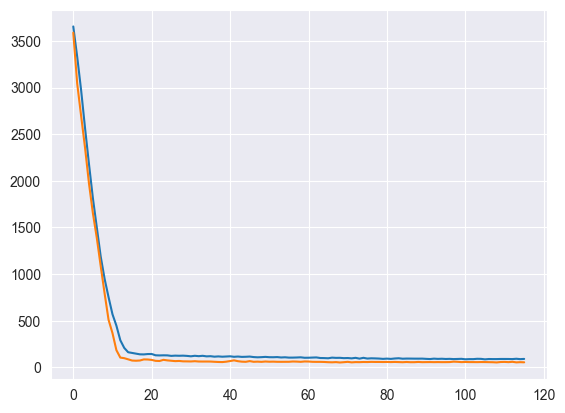

In [1468]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.show()

In [1469]:
print(y_test.shape)
print(X_test_scaled.shape)

(885,)
(885, 42)


In [1470]:
models.append(("sieć neuronowa", model))

print("sieć neuronowa")
print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test_scaled)) ))
print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test_scaled)) ))
print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test_scaled)) ))
print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test_scaled)) ))
print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test_scaled)) ))
r2.append(metrics.r2_score(y_test, model.predict(X_test_scaled)))
explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test_scaled)))
median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test_scaled)))
mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test_scaled)))
mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test_scaled)))

sieć neuronowa
28/28 [==============================] - 0s 985us/step
R^2: 0.4176506654783785
28/28 [==============================] - 0s 2ms/step
Explained variance score: 0.4232653752761383
28/28 [==============================] - 0s 1ms/step
Median absolute error: 3.9783782958984375
28/28 [==============================] - 0s 2ms/step
Mean squared error: 54.18936606450021
28/28 [==============================] - 0s 1ms/step
Mean absolute errors: 5.2395881911455575
28/28 [==============================] - 0s 1ms/step


In [1471]:
import pandas as pd
d = {'r_squared': r2,
     'explained_variance_score': explained_variance_score,
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['Logistic Regression', 'Ridge', 'Lasso', 'Elastic Net', 'SVC kernel rbf', 'SVC kernel poly', 'Random Forest Classifier', 'sieć neuronowa'])
df

,Method,r_squared,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,Logistic Regression,0.160092,0.187759,5.000000,78.155932,6.429379
1,Ridge,0.358433,0.358852,4.390087,59.699738,5.502323
2,Lasso,0.357716,0.358066,4.266316,59.766441,5.508121
3,Elastic Net,0.353152,0.353522,4.379645,60.191155,5.529078
4,SVC kernel rbf,0.048571,0.050083,4.000000,88.533333,6.162712
5,SVC kernel poly,0.197869,0.215545,5.000000,74.640678,6.213559
6,Random Forest Classifier,0.328152,0.338159,4.000000,62.517514,5.620339
7,sieć neuronowa,0.417651,0.423265,3.978378,54.189366,5.239588


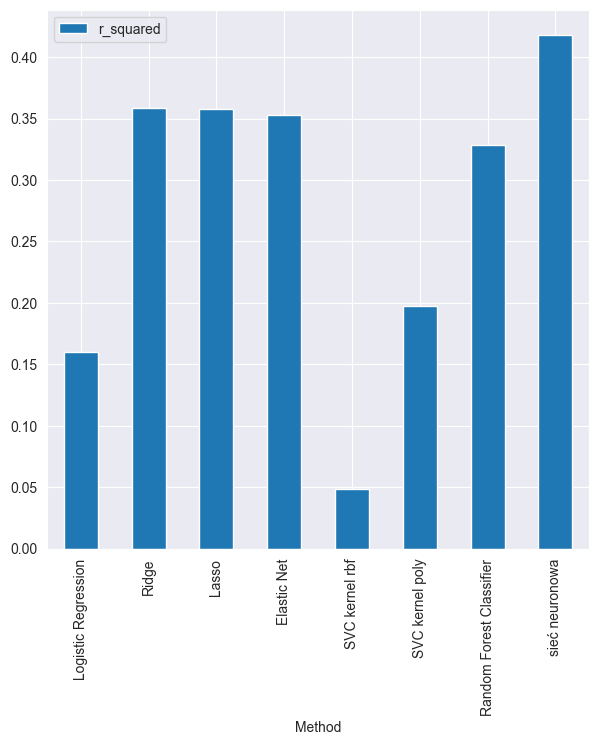

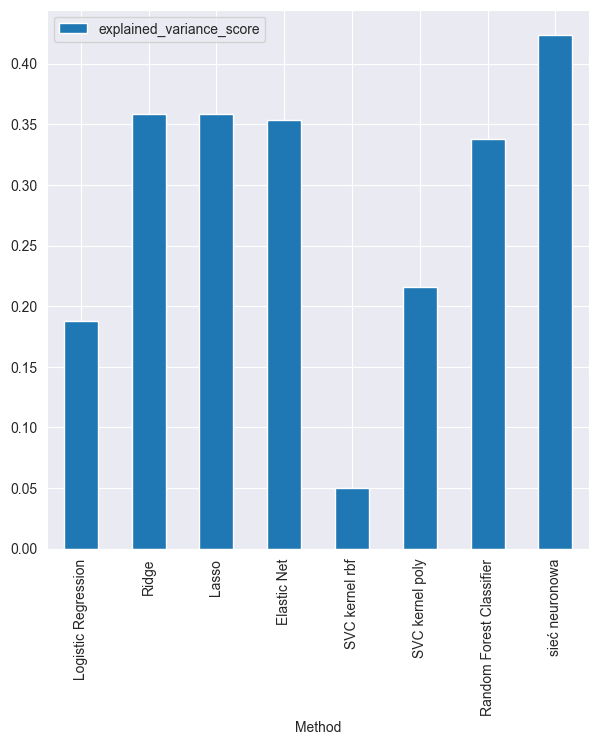

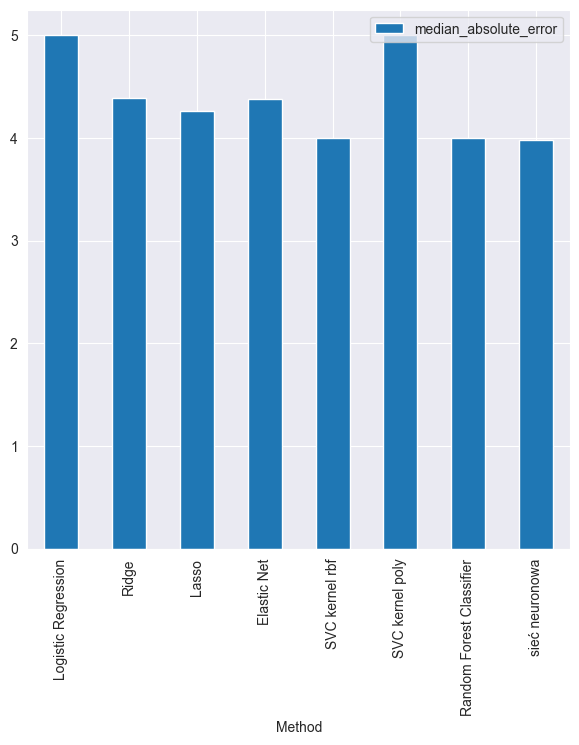

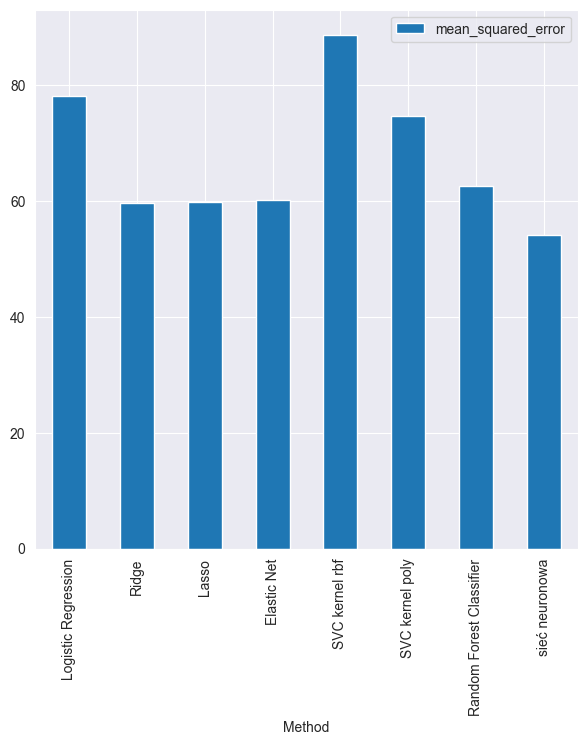

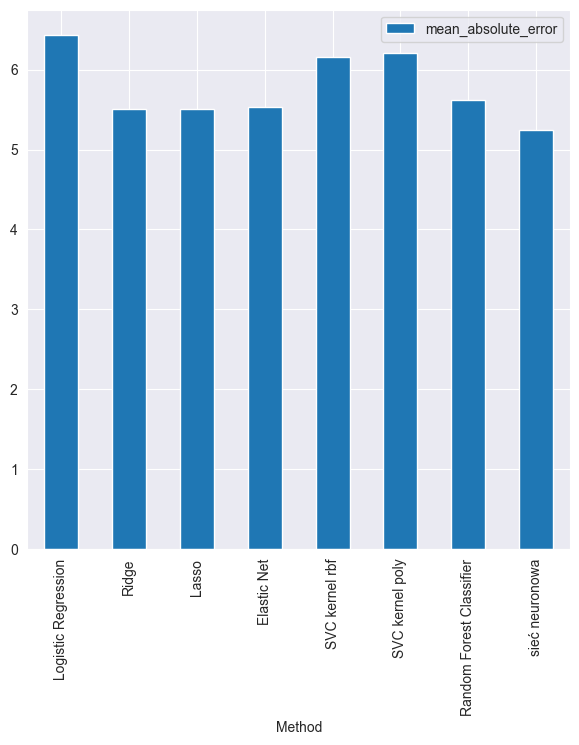

In [1474]:
for col in df.columns[1:]:
  df.plot.bar(x = 'Method', y = col, figsize = (7, 7))
  plt.show()